# Topic Modeling Demo: Latent Dirichlet Analysis w/ Gensim

## Install Libraries; A lot of these are for pre-processing, but some of them are for the actual model. We will be using gensim to create the actual model.  

In [1]:
import pandas as pd 
from textblob import TextBlob
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize, pos_tag
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
from gensim import corpora, models
from gensim import matutils, models
import scipy.sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text
import numpy as np
from helper import *
import pickle
nltk.download('wordnet');

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\iyerr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read in the data 

In [2]:
sotu = pd.read_csv('stateunion.tsv', sep='\t',  dtype={'texts':str, 'date':str, 'name':str}, index_col=0)
sotu = sotu.T # We want each speech to be a row instead of a column 
sotu = sotu.reset_index().drop(columns = ['index']) # get rid of row index
sotu = sotu.rename(columns = {'date':'y/m/d', 'name':'president', 'texts':'speech'}) # rename column for clarity purposes
sotu['y/m/d'] = pd.to_datetime(sotu['y/m/d']) # re-format structure of time data
for i in range(len(sotu['speech'])): # get rid of HTML tags and newlines 
    sotu['speech'][i] = re.sub('(?<! )(?<=[.,!:?();])(?! )', r' ', re.sub('<[^<]+?>', '', sotu['speech'][i]).replace('\n', ''))
sotu['word count'] = [len(speech.split(' ')) for speech in sotu['speech'].values] #count number of words per speech 
sotu['type'] = ['spoken' if count <= 12000 else 'written' for count in sotu['word count']] #classify speech type 
presidents = pd.read_csv('revised_presidents.csv') # Data File containing information about every president in SOTU dataset
presidents = presidents.drop(columns = ["Presidency ", "Wikipedia Entry",'Took office ', "Left office ", "Portrait", 'Thumbnail'])
# line above drops unnecessary columns 
sotu = sotu.join(presidents.set_index('President '), on='president') # merge our datasets
sotu.iloc[184] = sotu.iloc[184].fillna({'Party ': 'Republican', 'Home State':'Michigan'}) #fix nulls after merge 
sotu.iloc[185] = sotu.iloc[185].fillna({'Party ': 'Republican', 'Home State':'Michigan'}) 
sotu.iloc[186] = sotu.iloc[186].fillna({'Party ': 'Republican', 'Home State':'Michigan'})
sotu.iloc[218] = sotu.iloc[218].fillna({'Party ': 'Democratic', 'Home State':'Illinois'})
sotu.iloc[219] = sotu.iloc[219].fillna({'Party ': 'Democratic', 'Home State':'Illinois'})
sotu.iloc[220] = sotu.iloc[220].fillna({'Party ': 'Democratic', 'Home State':'Illinois'})
sotu.iloc[221] = sotu.iloc[221].fillna({'Party ': 'Democratic', 'Home State':'Illinois'})
sotu.iloc[222] = sotu.iloc[222].fillna({'Party ': 'Democratic', 'Home State':'Illinois'})
sotu.iloc[223] = sotu.iloc[223].fillna({'Party ': 'Democratic', 'Home State':'Illinois'})
sotu.iloc[224] = sotu.iloc[224].fillna({'Party ': 'Democratic', 'Home State':'Illinois'})
sotu.iloc[225] = sotu.iloc[225].fillna({'Party ': 'Democratic', 'Home State':'Illinois'})
sotu['year'] = sotu['y/m/d'].dt.year # for ease of formatting
sotu = sotu.rename(columns = {'Party ': 'party', 'Home State':'home state'}) #fix formatting issues
sotu['party'] = sotu['party'].str.strip(' ') #fix formatting issues

def get_polarity(text): # add polarity score of speech to dataframe
    """Return the polarity of TEXT"""   
    blob = TextBlob(text)
    return blob.sentiment.polarity

polarities = sotu['speech'].apply(get_polarity)
sotu['polarity'] = polarities #update dataframe with polarity scores 
sotu.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,y/m/d,president,speech,word count,type,party,home state,year,polarity
0,1790-01-08,George Washington,Fellow-Citizens of the Senate and House of Rep...,1008,spoken,Independent,Virginia,1790,0.235029
1,1791-10-25,George Washington,Fellow-Citizens of the Senate and House of Rep...,2148,spoken,Independent,Virginia,1791,0.131196
2,1792-11-06,George Washington,Fellow-Citizens of the Senate and House of Rep...,1959,spoken,Independent,Virginia,1792,0.078748
3,1793-12-03,George Washington,Fellow-Citizens of the Senate and House of Rep...,1830,spoken,Independent,Virginia,1793,0.093337
4,1794-11-19,George Washington,Fellow-Citizens of the Senate and House of Rep...,2706,spoken,Independent,Virginia,1794,0.115751


## Text Pre-Processing; this is very time intensive and also depends a lot on the dataset that you are working with. 

In [3]:
"""!mkdir transcripts

for i, c in enumerate(year):
    with open("transcripts/" + c + ".txt", "wb") as file:
        pickle.dump(documents[i], file)
"""
documents = sotu['speech'].values
year = sotu['y/m/d'].dt.year.astype(str)
stemmer = SnowballStemmer('english')
data = {} # data dictionary
for i, c in enumerate(year):
    with open("transcripts/" + c + ".txt", "rb") as file:
        data[c] = pickle.load(file)
        
        
def combine_text(list_of_text): 
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ''.join(list_of_text)
    return combined_text

def combine_text_new(list_of_text): 
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

data_combined = {key: [combine_text(value)] for (key, value) in data.items()}
pd.set_option('max_colwidth',150)

frame = pd.DataFrame.from_dict(data_combined).transpose()
frame.columns = ['speech']
frame = frame.sort_index()

def basic_processing(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

basic = lambda x: basic_processing(x)

basic_frame = pd.DataFrame(frame.speech.apply(basic))

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

f1 = lambda x: lemmatize_stemming(x)
preprocessor = lambda x: preprocess(x)

inter = pd.DataFrame(basic_frame.speech.apply(f1))
inter_1 = pd.DataFrame(inter.speech.apply(preprocess))
final = pd.DataFrame(inter_1.speech.apply(combine_text_new)) 

final.head()

,speech
1790,fellow citizen senat hous repres embrac great satisfact opportun present itselfof congratul present favor prospect publicaffair recent access impo...
1791,fellow citizen senat hous repres vain expect peac indian frontier long alawless unprincipl wretch violat right hospit infring solemn treati receiv...
1792,fellow citizen senat hous repres abat satisfact meet thepres occas felicit continu general abl inform theindian hostil time past distress ournorth...
1793,fellow citizen senat hous repres commenc term call intooffic occas aris express fellow citizen atlarg deep respect sens feel renew testimonyof pub...
1794,fellow citizen senat hous repres mind gracious indulg heaven theamerican peopl nation survey general prosper ofour countri look forward rich power...


## Convert dataframe to document-term matrix for model

In [4]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(final.speech)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = final.index
#data_dtm.to_pickle("dtm.pkl") #save to local directory

#final.to_pickle('final.pkl') #save to local directory
#pickle.dump(cv, open("cv.pkl", "wb")) # read into memory

## Now, we can start creating models. 

## Model #1: Include All Words

In [5]:
data = pd.read_pickle('dtm.pkl') #read in our document-term matrix
tdm = data.transpose() # change document-term matrix to term-document matrix for model
sparse_counts = scipy.sparse.csr_matrix(tdm) # construct sparse csr matrix
corpus = matutils.Sparse2Corpus(sparse_counts) # create gensim corpus for model
cv = pickle.load(open("cv.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=20)
lda.print_topics()

[(0,
  '0.009*"year" + 0.009*"nation" + 0.007*"peopl" + 0.006*"american" + 0.006*"world" + 0.006*"work" + 0.005*"govern" + 0.005*"congress" + 0.005*"america" + 0.005*"need"'),
 (1,
  '0.013*"state" + 0.010*"govern" + 0.007*"unit" + 0.006*"year" + 0.006*"congress" + 0.005*"countri" + 0.005*"nation" + 0.004*"public" + 0.004*"great" + 0.004*"power"')]

## Model #2: Include only Nouns 

In [6]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

data_clean = pd.read_pickle('final.pkl')
data_nouns = pd.DataFrame(data_clean.speech.apply(nouns))

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.speech)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
#data_dtmn.head()

# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

ldnoun = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=20)
ldnoun.print_topics()

[(0,
  '0.021*"state" + 0.011*"unit" + 0.009*"year" + 0.008*"congress" + 0.007*"countri" + 0.007*"nation" + 0.007*"power" + 0.005*"import" + 0.004*"duti" + 0.004*"peopl"'),
 (1,
  '0.015*"year" + 0.015*"nation" + 0.009*"world" + 0.009*"work" + 0.008*"peopl" + 0.007*"state" + 0.007*"congress" + 0.005*"countri" + 0.005*"program" + 0.004*"unit"')]

## Model #3: Nouns and Adjectives

In [7]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

data_nouns_adj = pd.DataFrame(data_clean.speech.apply(nouns_adj))
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.speech)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna.head()

# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

lda_noun_adj = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
for idx, topic in lda_noun_adj.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.005*"america" + 0.005*"program" + 0.004*"help" + 0.004*"feder" + 0.003*"econom" + 0.003*"busi" + 0.003*"problem" + 0.003*"budget" + 0.003*"plan" + 0.003*"live"


Topic: 1 
Words: 0.004*"subject" + 0.004*"general" + 0.003*"treati" + 0.003*"depart" + 0.003*"condit" + 0.003*"report" + 0.003*"constitut" + 0.003*"question" + 0.003*"claim" + 0.002*"attent"




Looking at the sets of words each model outputs, we get the most distinct sets in the third model. It looks like the noun and adjective LDA model is the most useful for us. We can try to interpret the topic that these sets of words pertain to. Looking at the words, we can see that the topics are roughly: 

Topic 0: Domestic Wellness
Topic 1: Legal Issues

### Now, let's try to look at the most prevalent topic in each SOTU speech to get an idea of how topics have changed over time. 

In [8]:
corpus_transformed = lda_noun_adj[corpusna]
a = []
for topic in corpus_transformed:
    if len(topic) > 1:
        val1 = topic[0][1]
        val2 = topic[1][1]
        if val1 > val2:
            a.append(topic[0][0])
        else:
            a.append(topic[1][0])
    else:
        a.append(topic[0][0])
topic_trend = list(zip(a, data_dtmna.index))
topic_trend

[(1, '1790'),
 (1, '1791'),
 (1, '1792'),
 (1, '1793'),
 (1, '1794'),
 (1, '1795'),
 (1, '1796'),
 (1, '1797'),
 (1, '1798'),
 (1, '1799'),
 (1, '1800'),
 (1, '1801'),
 (1, '1802'),
 (1, '1803'),
 (1, '1804'),
 (1, '1805'),
 (1, '1806'),
 (1, '1807'),
 (1, '1808'),
 (1, '1809'),
 (1, '1810'),
 (1, '1811'),
 (1, '1812'),
 (1, '1813'),
 (1, '1814'),
 (1, '1815'),
 (1, '1816'),
 (1, '1817'),
 (1, '1818'),
 (1, '1819'),
 (1, '1820'),
 (1, '1821'),
 (1, '1822'),
 (1, '1823'),
 (1, '1824'),
 (1, '1825'),
 (1, '1826'),
 (1, '1827'),
 (1, '1828'),
 (1, '1829'),
 (1, '1830'),
 (1, '1831'),
 (1, '1832'),
 (1, '1833'),
 (1, '1834'),
 (1, '1835'),
 (1, '1836'),
 (1, '1837'),
 (1, '1838'),
 (1, '1839'),
 (1, '1840'),
 (1, '1841'),
 (1, '1842'),
 (1, '1843'),
 (1, '1844'),
 (1, '1845'),
 (1, '1846'),
 (1, '1847'),
 (1, '1848'),
 (1, '1849'),
 (1, '1850'),
 (1, '1851'),
 (1, '1852'),
 (1, '1853'),
 (1, '1854'),
 (1, '1855'),
 (1, '1856'),
 (1, '1857'),
 (1, '1858'),
 (1, '1859'),
 (1, '1860'),
 (1, '

## Visualization

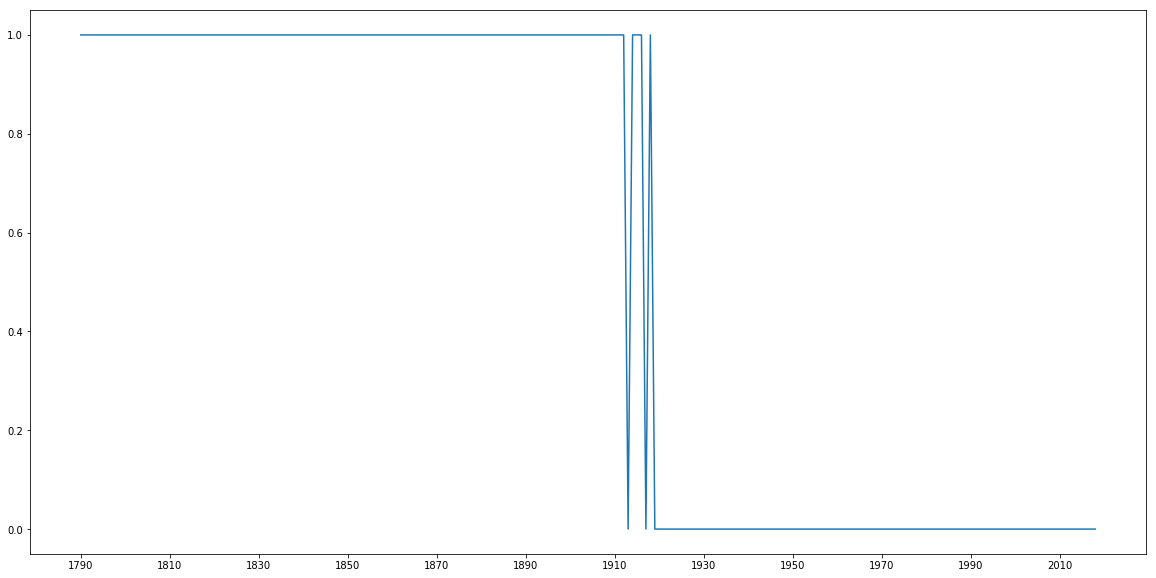

In [9]:
topics = []
years = []
for item in topic_trend:
    topics.append(item[0])
    years.append(item[1])
years = [int(x) for x in years]
frame = pd.DataFrame({'Topics':topics, 'Years':years})
plt.figure(figsize = (20, 10))
plt.xticks(np.arange(1790, 2020, 20))
plt.plot(years, topics);

## Let's Focus in on the spike in the middle

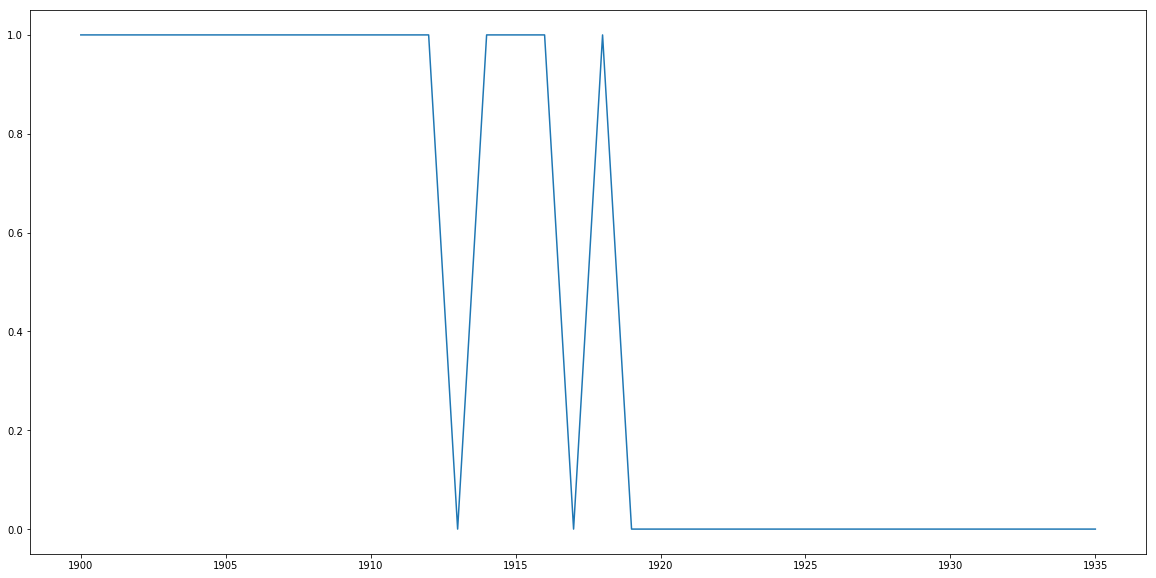

In [10]:
new_frame = frame[(frame['Years'] >= 1900) & (frame['Years'] <= 1935)]
plt.figure(figsize = (20, 10))
plt.plot(new_frame['Years'], new_frame['Topics']);

## Explanations?

### Possibly correlated with switch in speech formats (written to spoken)
### Could be in related to a change in intent (ie. speaking about legislation vs. vision of the country)